In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN
from pandas.core.common import random_state
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RepeatedStratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from main import y_train

    ID  Cardiomegaly  Heart_width  Lung_width  CTR_-_Cardiothoracic_Ratio  \
0    1             0          172         405                    0.424691   
1    2             1          159         391                    0.406650   
2    5             0          208         400                    0.520000   
3    7             1          226         435                    0.519540   
4    8             1          211         420                    0.502381   
5    9             1          222         405                    0.548148   
6   10             1          202         498                    0.405622   
7   11             1          228         474                    0.481013   
8   12             0          176         449                    0.391982   
9   13             1          223         473                    0.471459   
10  14             1          195         415                    0.469880   
11  15             1          195         429                    0.454545   

### Problem Overview

The goal is to build a model that can predict whether a patient has heart with hypertrophic cardiomyopathy based on features such as:
- lung width
- heart width
- cr ratio
- interia tensors
- inscribed circle radius
- polygon area ratio
- heart perimeter
- heart area
- lung area

Each row in the dataset represents one patient, and the target column — "Cardiomegaly" — indicates the outcome:

1 → positive diagnosis (diseased heart)

0 → negative diagnosis (healthy heart)

### Data Loading and Formating

In [4]:
# Loading data into df
data = pd.read_csv("task_data.csv")
print(data)

    ID  Cardiomegaly  Heart width  Lung width CTR - Cardiothoracic Ratio  \
0    1             0          172         405                0,424691358   
1    2             1          159         391               0,4066496164   
2    5             0          208         400                       0,52   
3    7             1          226         435               0,5195402299   
4    8             1          211         420               0,5023809524   
5    9             1          222         405               0,5481481481   
6   10             1          202         498                 0,40562249   
7   11             1          228         474               0,4810126582   
8   12             0          176         449               0,3919821826   
9   13             1          223         473               0,4714587738   
10  14             1          195         415               0,4698795181   
11  15             1          195         429               0,4545454545   
12  17      

The column names in the data frame contain spaces.
We will convert them to standard naming conventions.

Notice that some numeric data uses a comma as a decimal separator.
We need to convert it to a standard point format.

In [5]:
# Data formating
# Changing column names
data.columns = data.columns.str.strip().str.replace(' ', '_')
# Converting data to the correct format
wrong_type_columns = ["CTR_-_Cardiothoracic_Ratio","Inscribed_circle_radius","Heart_perimeter"]
for col in wrong_type_columns:
    data[col] = data[col].astype(str).str.replace(',','.').astype(float)

### Selection of Data for Training

In [6]:
# data separation
X = data[[
    "Heart_width","Lung_width", "CTR_-_Cardiothoracic_Ratio",
    "xx","yy","xy","normalized_diff","Inscribed_circle_radius",
    "Polygon_Area_Ratio","Heart_perimeter","Heart_area", "Lung_area"
]]
y = data["Cardiomegaly"]
# avoiding splitting dataset (reason: not enough data)
X_train = X
y_train = y

### Model Training

The dataset includes both simple features, such as heart width, and more complex ones derived from image data—specifically, inertia centers represented as pixel distributions relative to an axis. A model well-suited for capturing non-linear relationships and analyzing image-like data is the Support Vector Machine (SVM). However, since SVMs are sensitive to the scale of input features, it is essential to normalize/standardise the data using an appropriate scaler beforehand.

In [31]:
#SVM
pipe_svc = Pipeline([
    ('generator',ADASYN(n_neighbors=3)), # Balances minority class using 3-neighbor oversampling
    ('scaler', StandardScaler()), # To standardize data
    ("model", SVC(
        kernel="rbf", # For non-linear relationships
        C=3, # Regularizes strength
        gamma="scale", # Adapts to data variance
        class_weight="balanced", # In cardiomegaly 1 occurs much more frequently than 0
        probability=True, # Enables probability estimates via cross-validation
    ))
])
# Cross-validation strategy that performs stratified K-fold splitting multiple times
cv = RepeatedStratifiedKFold(
    n_splits=5, # Splits data into 5 folds, preserving class proportions in each fold
    n_repeats=10, # Repeats the 5-fold split 10 times for more robust and averaged evaluation
    random_state=42 # Ensures reproducibility of fold splits across runs
)

# Evaluates model performance using cross-validation
cv_score = np.round(cross_val_score(pipe_svc, X_train, y_train,cv=cv,
    scoring="recall_macro"),  # Averages recall across classes, useful for imbalanced data
    2)

print("Scores of training data cross-validation (each fold):")
list(map(print, cv_score))
print(f"\nCross-validation mean score: {cv_score.mean():.3f}")
print(f"Standard deviation of CV score: {cv_score.std():.3f}")


# Generates predictions using cross validation
y_pred = cross_val_predict(pipe_svc, X_train, y_train)
# Prints precision, recall, f1-score for each class and overall averages
print(classification_report(y_train, y_pred, digits=3))

Scores of training data cross-validation (each fold):
0.42
0.92
0.75
0.65
0.92
0.67
0.67
0.5
1.0
0.92
0.33
0.75
0.5
0.75
0.92
0.67
0.42
1.0
0.65
0.5
0.67
0.5
0.4
0.65
0.92
0.67
0.67
0.4
0.75
0.42
0.67
0.75
0.5
0.9
0.92
0.42
0.67
0.75
1.0
0.33
0.5
1.0
0.65
0.5
0.42
0.67
0.42
0.4
0.9
0.92

Cross-validation mean score: 0.665
Standard deviation of CV score: 0.202
              precision    recall  f1-score   support

           0      0.500     0.556     0.526         9
           1      0.852     0.821     0.836        28

    accuracy                          0.757        37
   macro avg      0.676     0.688     0.681        37
weighted avg      0.766     0.757     0.761        37



Model achieved solid overall performance (accuracy = 78.4%, recall for class 1 = 0.857), but it only detected 5 out of 9 minority class samples (recall for class 0 = 0.556). Additionally, cross-validation results were unstable (standard deviation = 0.211), which is normal for small datasets. To improve minority class detection, we aim to increase recall for class 0 by adjusting ADASYN and SVC parameters to better balance the model’s focus.

### Hyperparameters Tuning

We will use GridSearchCV to correctly adjust ADASYN and SVC parameters

In [36]:
# Defines hyperparameter grid for ADASYN and SVC
param_grid = {
    'generator__n_neighbors': [2,3,4], # Oversampling strength
    'model__C': [0.5, 1, 3, 10], # Regularization
    'model__gamma': ['scale', 'auto'], # Kernel coefficient
    'model__kernel': ['rbf', 'poly'] # Kernel type
}

# Grid search with 5-fold CV to optimize recall_macro
grid = GridSearchCV(
    pipe_svc, param_grid,
    cv=5, # 5-fold cross-validation
    scoring='recall_macro',  # Optimizes for balanced recall across classes
    n_jobs=-1 # Uses all available cores for parallel processing
)

# Fits grid search on training data
grid.fit(X_train, y_train)

# Prints best parameter combination and corresponding recall_macro score
print("Best parameters:", grid.best_params_)
print("Best recall_macro:", grid.best_score_)

Best parameters: {'generator__n_neighbors': 4, 'model__C': 10, 'model__gamma': 'auto', 'model__kernel': 'poly'}
Best recall_macro: 0.7100000000000001


### Final Model

To build this model we will simply apply optimal parameters found using GridSearchCV to previous pipeline

In [9]:
# SVM with optimized parameters from GridSearchCV
pipe_svc = Pipeline([
    ('generator',ADASYN(n_neighbors=4,random_state=42)), # Balances minority class using 4-neighbor oversampling
    ('scaler',StandardScaler()), # Standardizes features to zero mean and unit variance
    ("model", SVC(
        kernel="poly",  # Uses polynomial kernel for non-linear decision boundaries
        C=10, # Low regularization, allows tighter fit to training data
        gamma="auto", # Sets gamma to 1 / num_features; ignores data variance; good for small datasets
        class_weight="balanced", # Adjusts for class imbalance (cardiomegaly: 1 >> 0)
        probability=True, # Enables probability estimates via cross-validation
        random_state=42
    ))
])
# Same setup as before
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
cv_score = np.round(cross_val_score(pipe_svc, X_train, y_train,cv=cv,scoring="recall_macro"), 2)

print("Scores of training data cross-validation (each fold):")
list(map(print, cv_score))
print(f"\nCross-validation mean score: {cv_score.mean():.3f}")
print(f"Standard deviation of CV score: {cv_score.std():.3f}")

y_pred = cross_val_predict(pipe_svc, X_train, y_train)
print(classification_report(y_train, y_pred, digits=3))

Scores of training data cross-validation (each fold):
0.42
0.58
1.0
0.55
0.92
0.5
0.67
0.65
1.0
0.33
0.33
0.83
0.65
0.65
0.5
0.67
0.33
0.8
1.0
0.5
0.67
0.42
0.5
0.65
0.92
0.5
0.5
1.0
0.4
0.42
0.67
0.75
0.4
0.7
0.67
0.75
0.58
0.55
1.0
0.83
0.58
1.0
0.55
0.55
0.92
0.83
0.58
0.55
0.9
0.83

Cross-validation mean score: 0.661
Standard deviation of CV score: 0.199
              precision    recall  f1-score   support

           0      0.545     0.667     0.600         9
           1      0.885     0.821     0.852        28

    accuracy                          0.784        37
   macro avg      0.715     0.744     0.726        37
weighted avg      0.802     0.784     0.791        37



The newer model is more balanced and effective, especially in recognizing the minority class (class 0). It maintains stability (SD = 0.199) and improves both overall and class-specific metrics. It is better suited for applications where performance across both classes is important. We will check a model based on ROC and AUC curve.

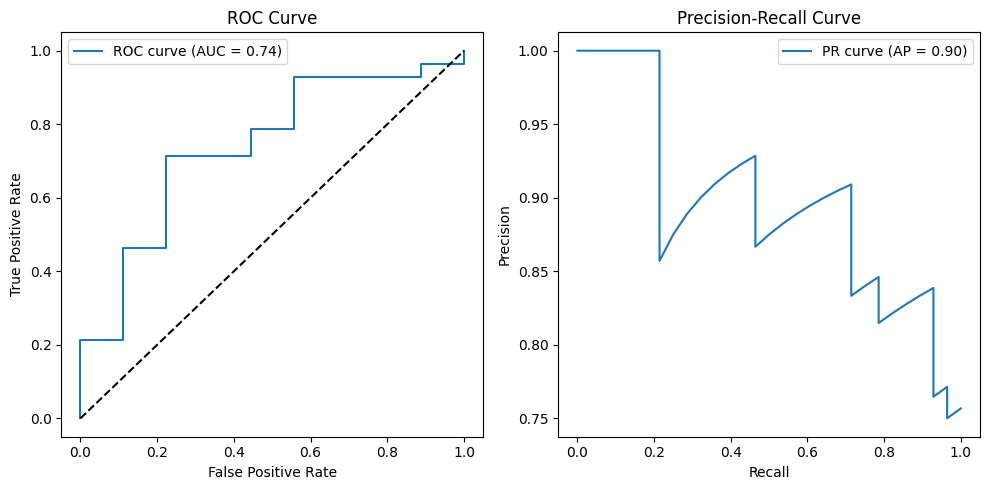

In [110]:
# Predict probabilities for ROC and PR curves
y_proba = cross_val_predict(pipe_svc, X_train, y_train, method='predict_proba')[:, 1]  # Probabilities for class 1

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_train, y_proba)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and average precision
precision, recall, _ = precision_recall_curve(y_train, y_proba)
avg_precision = average_precision_score(y_train, y_proba)

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()


ROC Curve (AUC = 0.74):
The model shows moderate ability to distinguish between classes. The curve rises above the random baseline, indicating useful but not perfect classification performance.

Precision-Recall Curve (AP = 0.90):
The model maintains high precision across a wide range of recall values. This is especially valuable for imbalanced datasets, showing strong performance in identifying the positive class.

Conclusion:
The model is reliable and well-suited for tasks where detecting the positive class accurately is critical, such as medical or fraud detection scenarios.

### Sumary

This model performs surprisingly well considering the small and imbalanced dataset. It maintains a solid balance between sensitivity and precision, especially in recovering minority class instances. While not flawless, its metrics and curve profiles show that it handles the data constraints with resilience. Considering the constraints of the dataset, its stable performance and minority class sensitivity are impressive.